### ⬇️ Imports & Configs
**⚠️ IMPORTANT: Run this before anything else**

*(You can change the hyperparameters within HYPER_PARAMS dict)*

In [26]:
!pip install -q tensorflow opencv-python pillow matplotlib scikit-learn

import os
import cv2
import math
import time
import random
import datetime
import threading
import numpy as np
import pandas as pd
import tensorflow as tf
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Hyperparameters can changed before starting
HYPER_PARAMS = {
    'IMG_SIZE': (299, 299), # Max: 299x299 for InceptionV3 but 224x224 also good
    'BATCH_SIZE': 24, # ~24 for Laptop, ~48 for PC
    'EPOCHS': 20, # 5 is ok, 12-18 is when it will early stop on its own
    'DATA_SPLIT': (80, 10, 10), # probably should not change
    'DISTRIBUTE_CLASS_WEIGHTS': True # Default: True, will alleviate uneven class image distribution
}

data_dir = './data'
class_names = os.listdir(data_dir) # ['Finished', 'Opened', 'Sealed']

print("✅ Done!")

✅ Done!


# Model Training
**Trains the model then saves it as a .keras model file.**

In [11]:
# Returns 3 shuffled data frames of the 80/10/10 data split
def build_df_splits():
    seed = 42 # seed only controls the df splits
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    files = []
    labels = []

    valid_ext = (".jpg", ".jpeg", ".png")

    for cls in class_names:
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue

        for f in os.listdir(cls_dir):
            if f.lower().endswith(valid_ext):
                files.append(os.path.join(cls_dir, f)) # gets all filepaths of images
                labels.append(cls) # gets all labels/class names of images

    df = pd.DataFrame({"filename": files, "class": labels})
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True) # randomises its order

    db_split = HYPER_PARAMS["DATA_SPLIT"]
    n = len(df) # total number of images
    train_end = int(db_split[0]/sum(db_split) * n) # 80%
    val_end = int((db_split[0] + db_split[1])/sum(db_split) * n) # 90%

    train_df = df[:train_end] # 80% goes to training dataframe
    val_df   = df[train_end:val_end] # 10% goes to training dataframe
    test_df  = df[val_end:] # 10% goes to training dataframe

    return train_df, val_df, test_df

# returns the 3 respective image generators
def build_image_generators(train_df, val_df, test_df):
    img_size = HYPER_PARAMS["IMG_SIZE"]
    batch_size = HYPER_PARAMS["BATCH_SIZE"]

    train_datagen = ImageDataGenerator(
        rescale=1./255, # normalizes pixel values
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True # 5 methods of data augmentation
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255) # only normalize pixel values, no data aug

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col="filename",
        y_col="class",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col="filename",
        y_col="class",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    test_gen = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col="filename",
        y_col="class",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen, test_gen

def build_model():
    base_model = InceptionV3(input_shape=(*HYPER_PARAMS["IMG_SIZE"], 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Start of program flow

# 1. Generates ImageGens for each class in dataset
print("\n📊 Loading data...")
train_df, val_df, test_df = build_df_splits()
train_gen, val_gen, test_gen = build_image_generators(train_df, val_df, test_df)

# 2. Alleviates uneven class image counts
if HYPER_PARAMS["DISTRIBUTE_CLASS_WEIGHTS"]: # if True
    print("\n⚖️ Balancing class weights...")
    class_weights = compute_class_weight(
        'balanced', classes=np.unique(train_gen.classes), y=train_gen.classes
    )
    class_indices = train_gen.class_indices
    class_weight_dict = {class_indices[class_name]: weight 
                        for class_name, weight in zip(class_indices.keys(), class_weights)}
else:
    class_weight_dict = None

# 3. Build the model's layers
print("\n🔨 Building model...") 
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Training the model
print("\n🚀 Training...")
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'), # patience means wait x epochs before doing smth
    ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-7) # slows learning rate to prevent it from bouncing
]
start_time = time.time()
history = model.fit(
    train_gen,
    epochs=HYPER_PARAMS['EPOCHS'],
    validation_data=val_gen,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1 # prints the cool progress bar
)
training_time = time.time() - start_time
model_accuracy = model.evaluate(test_gen)[1]

# 5. Simple post-training metrics
print(f"⌛ Total training time: ({training_time/60:.2f} minutes)")
print("\n✅ Test accuracy:", model_accuracy)

# 6. Save the model as a .keras file with accuracy & timestamp
timestamp = datetime.datetime.now().strftime("%b%d_%H%M")
filename = f"{int(model_accuracy * 100)}acc_model_{timestamp}.keras"
model.save(f'./models/{filename}')
print(f"💾 Saved: {filename}")


📊 Loading data...
Found 1424 validated image filenames belonging to 3 classes.
Found 178 validated image filenames belonging to 3 classes.
Found 179 validated image filenames belonging to 3 classes.

⚖️ Balancing class weights...

🔨 Building model...

🚀 Training...
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.7886 - loss: 0.5393 - val_accuracy: 0.7360 - val_loss: 0.5707 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.8912 - loss: 0.2875 - val_accuracy: 0.9270 - val_loss: 0.2083 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9052 - loss: 0.2531 - val_accuracy: 0.9551 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9199 - loss: 0.2024 - val_accuracy: 0.9663 - val_loss: 0.1094 - learning_rate: 0.0010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9424 - loss: 0.1794 - val_accuracy: 0.9438 - val_loss: 0.1206 - 

## ======================================
# Trying the Model

### 🔃 Load a .keras model
Loading a model is necessary if the above code to train a new model was not executed.
(Skip this if model was recently trained above)

🔴 Option A - Load the latest model

In [25]:
folder = "./models/"
files = [f for f in os.listdir(folder) if f.endswith('.keras')]
if not files: raise FileNotFoundError("❌ No models found!")
latest_model = max(files, key=lambda f: os.path.getmtime(os.path.join(folder, f)))
model = tf.keras.models.load_model(os.path.join(folder, latest_model))
print("✅ Loaded Latest Model:", latest_model)

✅ Loaded Latest Model: 97acc_model_jupyter.keras


🔵 Option B - Load other models

In [13]:
folder = "./models/"
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
model_paths = filedialog.askopenfilenames(
    title="Select model file (.keras)",
    initialdir=folder,
    filetypes=[("Keras models", "*.keras")]
)
root.destroy()
if not model_paths: raise FileNotFoundError("❌ No model selected.")
full_path = model_paths[0]
model_filename = os.path.basename(full_path)
model = tf.keras.models.load_model(full_path)
print("✅ Loaded Model:", model_filename)

✅ Loaded Model: 97acc_model_jupyter.keras


### Method 1: Inference using Camera Stream 📷 
(Please view the cell under this one to terminate the camera)

In [14]:
def import_and_predict(image_data):
    image = ImageOps.fit(image_data, HYPER_PARAMS['IMG_SIZE'], Image.Resampling.LANCZOS)
    image = image.convert('RGB')
    image = np.asarray(image)
    image = (image.astype(np.float32) / 255.0)
    img_reshape = image[np.newaxis,...]
    prediction = model.predict(img_reshape, verbose=0)
    return prediction

stop_flag = False

def camera_loop():
    global stop_flag
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        cap.open()
        
    print("Camera Started!")

    while not stop_flag:
        ret, original = cap.read()
        if not ret:
            break

        image = Image.fromarray(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        prediction = import_and_predict(image)

        idx = np.argmax(prediction)
        confidence = prediction[0][idx] 

        predict = f"It is {class_names[idx]}! ({confidence:.2f})"

        cv2.putText(original, predict, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow("Cup Noodles Detector", original)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            stop_flag = True

    cap.release()
    cv2.destroyAllWindows()

# start the camera in a separate thread
camera_thread = threading.Thread(target=camera_loop)
camera_thread.start()

Camera Started!


❌ Run to terminate the camera! 👇

In [15]:
stop_flag = True
camera_thread.join()
print("💀 Killed the Camera!")

💀 Killed the Camera!


### Method 2: Inference using Image File Upload 🖼️ 

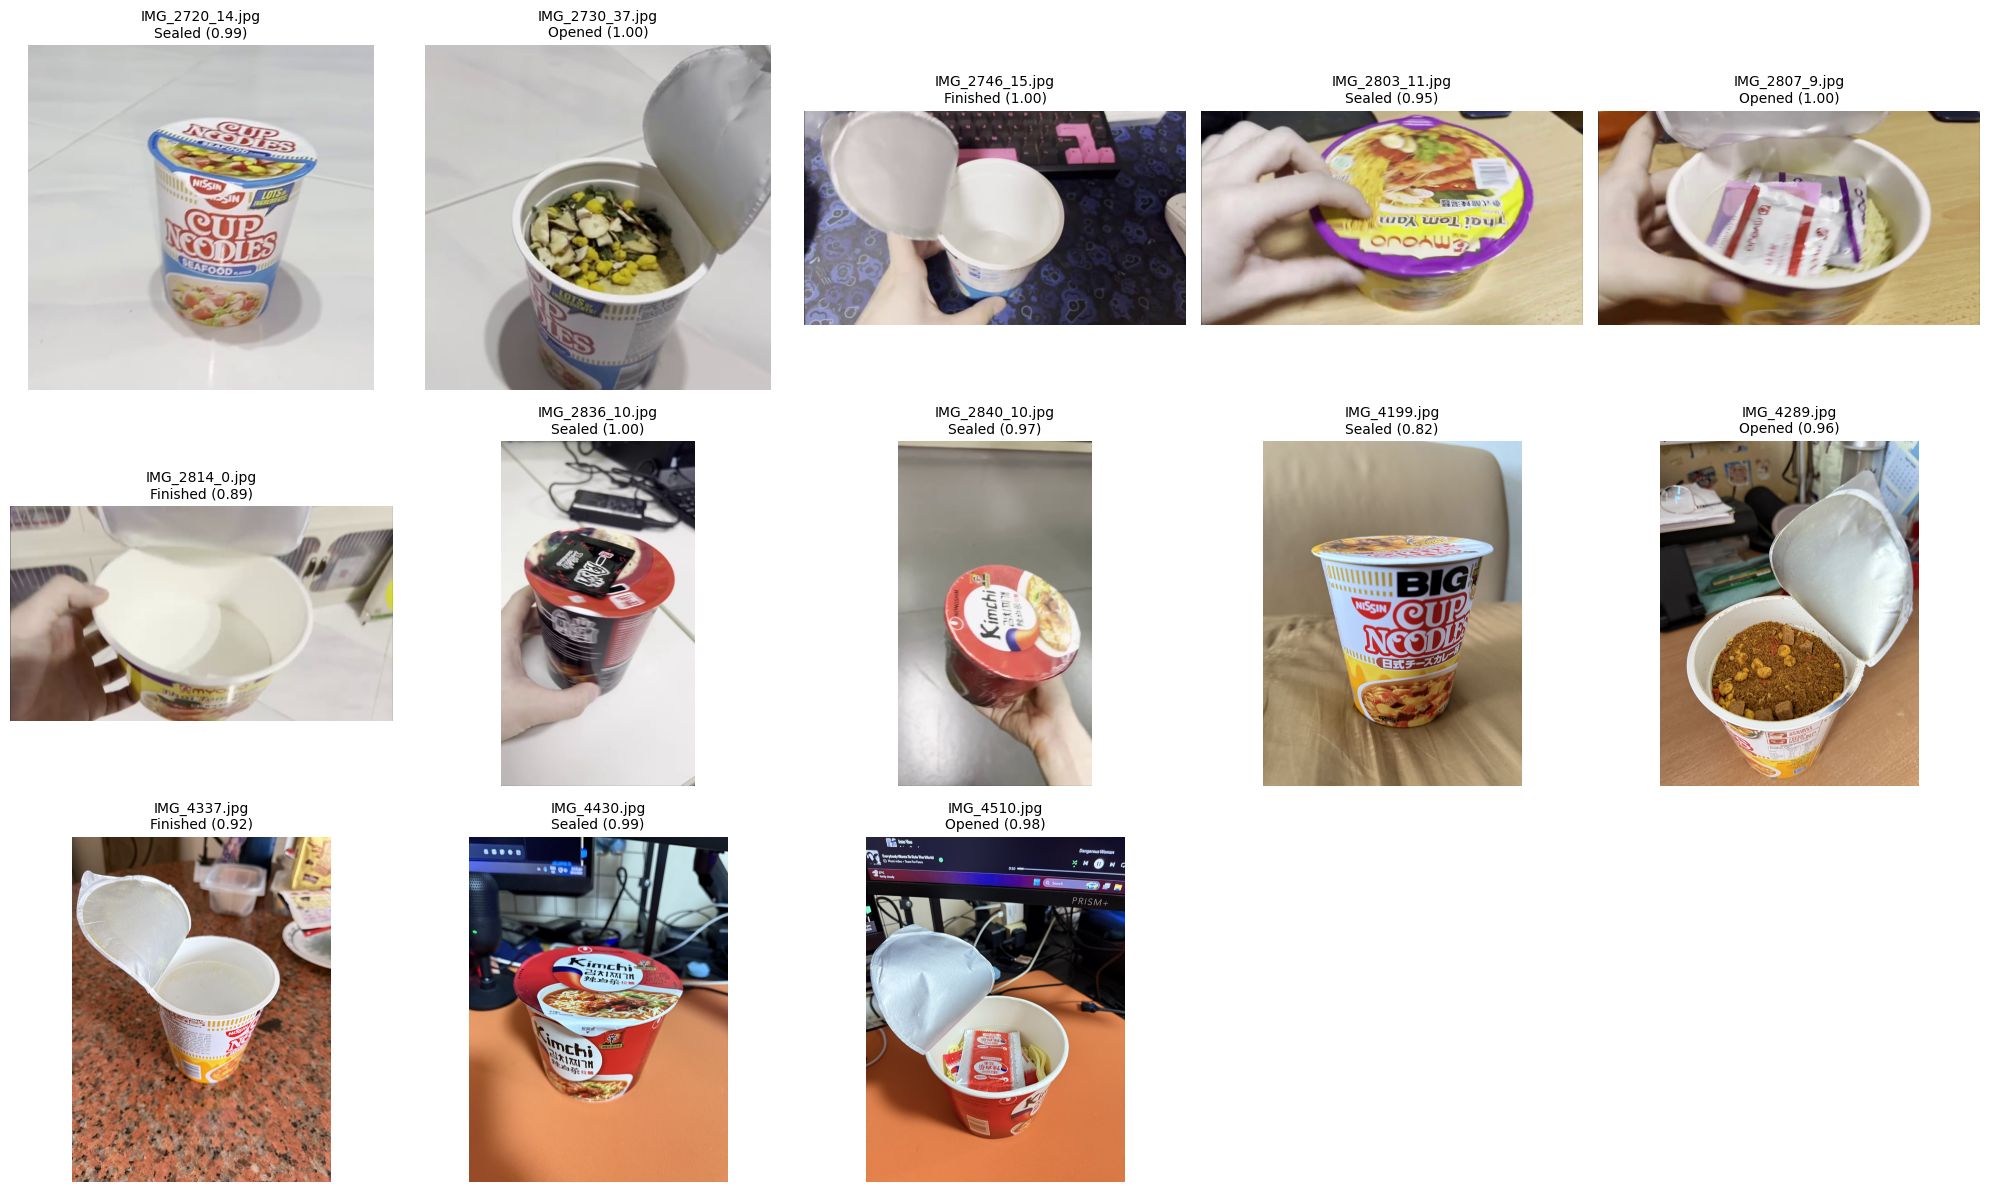

In [21]:
COLUMNS = 5

def visualize_predictions_from_files(image_paths):
    rows = math.ceil(len(image_paths) / COLUMNS)
    plt.figure(figsize=(COLUMNS * 4, rows * 4))
    
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # decodes rgb before going into plt
        img_resized = cv2.resize(img, HYPER_PARAMS["IMG_SIZE"])
        img_norm = img_resized / 255.0
        img_input = np.expand_dims(img_norm, axis=0)
        
        preds = model.predict(img_input, verbose=0)
        class_id = np.argmax(preds[0])
        confidence = preds[0][class_id]
        filename = os.path.basename(img_path) 
        
        plt.subplot(rows, COLUMNS, i + 1)
        plt.imshow(img)
        plt.title(f"{filename}\n{class_names[class_id]} ({confidence:.2f})", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.close()

root = tk.Tk()
root.withdraw() 
root.attributes('-topmost', True)
file_paths = filedialog.askopenfilenames(
    title="Select images to predict",
    filetypes=[("Image files", "*.jpg *.jpeg *.png")]
)
root.destroy()
visualize_predictions_from_files(list(file_paths))

## ======================================
# Data Visualization

### ⚖️ Check Class Balance
**Even though the code already distributes class weights, it still helps to know which**

Dataset Balance:
{'Finished': 565, 'Opened': 541, 'Sealed': 675}
Ratios: {'Finished': '31.7%', 'Opened': '30.4%', 'Sealed': '37.9%'}
Total:  1781


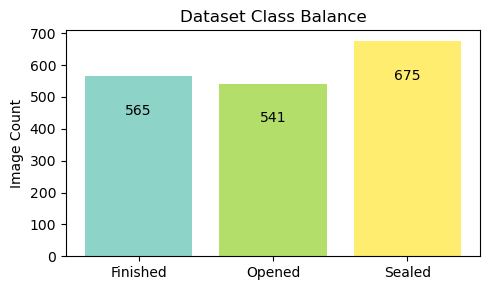

In [17]:
def check_dataset_balance():
    counts = {}
    for class_dir in sorted(class_names): 
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            counts[class_dir] = len([f for f in os.listdir(class_path) 
                                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    
    total = sum(counts.values())
    print("Dataset Balance:")
    print(counts)
    print("Ratios:", {k: f"{v/total*100:.1f}%" for k,v in counts.items()})
    print("Total: ", total)

    plt.figure(figsize=(5, 3))
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    bars = plt.bar(class_names, counts.values(), color=colors)
    plt.bar_label(bars, padding=-30) 
    plt.ylabel('Image Count')
    plt.title('Dataset Class Balance')
    plt.tight_layout()
    plt.show()
    plt.close()

check_dataset_balance()

### Accuracy & Loss over Epochs
**Helps detecting overfitting (when acc >>> val_acc) and view model convergence over epochs**

(🏳️ PREREQUISITE: Execute and finish model training above)

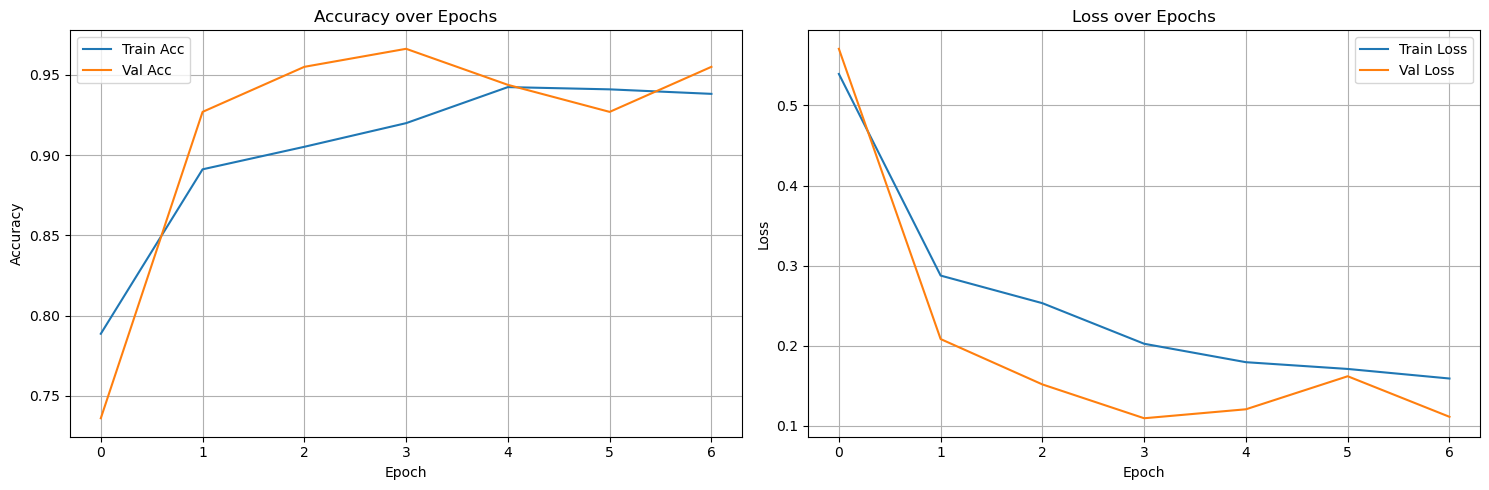

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Acc')
axes[0].plot(history.history['val_accuracy'], label='Val Acc')
axes[0].set_title('Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
plt.close()

### Confusion Matrix
**Figure out which classes are confusing the model, and have higher error rate.**

(🏳️ PREREQUISITE: Execute and finish model training above)

🔄 Computing predictions...


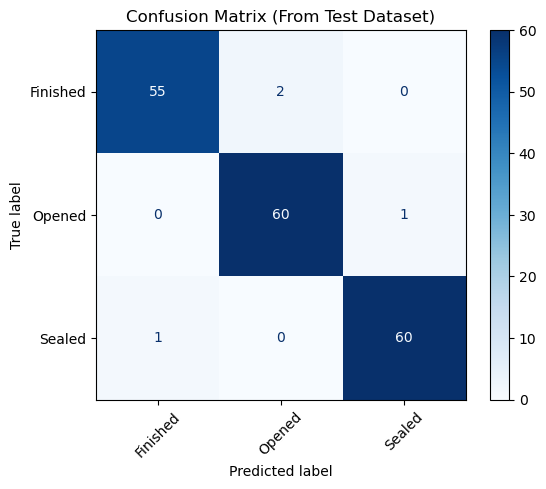

In [22]:
if 'y_pred_prob' not in locals(): # skips code if already have the values
    print("🔄 Computing predictions...")
    test_gen.reset() # resets generator's pointer to 0
    y_pred_prob = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1) # predictions
    y_true = test_gen.classes # labels

cm = confusion_matrix(y_true, y_pred)
cmdisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmdisplay.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix (From Test Dataset)')
plt.show()
plt.close()

### Statistics
**Displays Precision, Recall F1-Score and Support.**
- **Precision > Recall** - *means model is too careful.*
- **Recall > Precision** - *means model is more likely to make false alarms.*

(🏳️ PREREQUISITE: Execute and finish model training above)

In [23]:
if 'y_pred_prob' not in locals():
    print("🔄 Computing predictions...")
    test_gen.reset()
    y_pred_prob = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Finished       0.98      0.96      0.97        57
      Opened       0.97      0.98      0.98        61
      Sealed       0.98      0.98      0.98        61

    accuracy                           0.98       179
   macro avg       0.98      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179



### Misclassified Images
**Figure out which images exactly are confusing the model.**
- This could possibly help us find images that were put in the wrong class, or are poorly taken.
- This also highlights the characteristics of some images that the model is not trained well enough to classify correctly.

🔍 Found 4 misclassified images


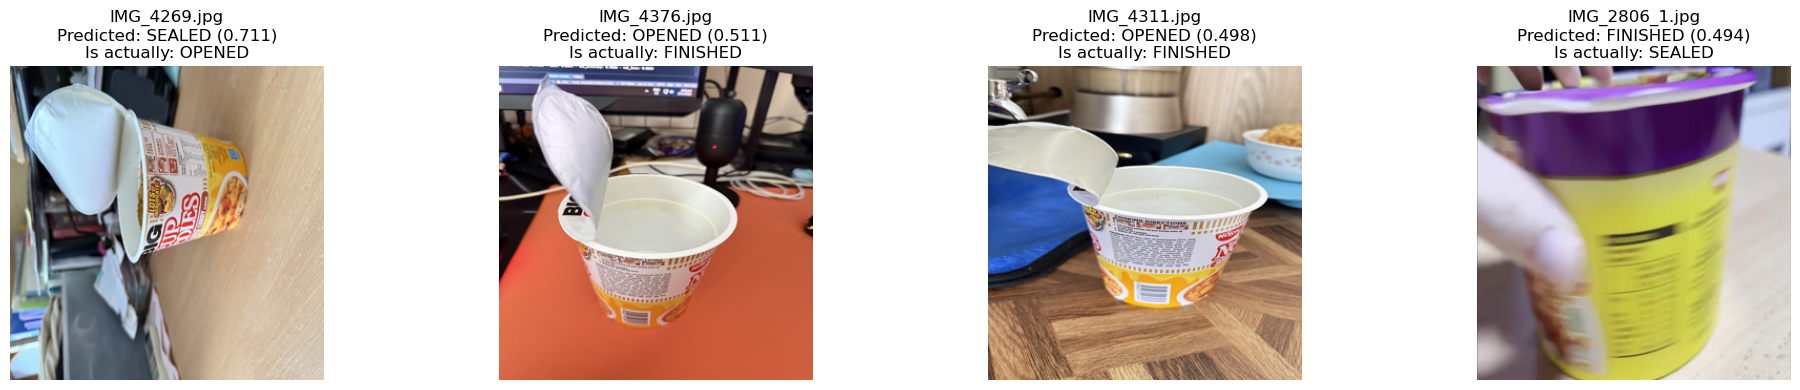

In [24]:
COLUMNS = 4
SORT_BY_DESCENDING_CONFIDENCE = True

if 'y_pred_prob' not in locals(): # skips code if already have the values
    print("🔄 Computing predictions...")
    test_gen.reset() # resets generator's pointer to 0
    y_pred_prob = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1) # predictions
    y_true = test_gen.classes # labels

mis_idx = np.where(y_true != y_pred)[0]
confidences = np.max(y_pred_prob[mis_idx], axis=1)
misclassified = test_df.iloc[mis_idx].copy()
misclassified['pred_class'] = [class_names[p] for p in y_pred[mis_idx]]
misclassified['confidence'] = confidences 

misclassified = misclassified.sort_values('confidence', ascending=not SORT_BY_DESCENDING_CONFIDENCE) # Sort by highest confidence first

print(f"🔍 Found {len(misclassified)} misclassified images")

count = len(misclassified)
rows = (count + COLUMNS - 1) // COLUMNS 

fig, axes = plt.subplots(rows, COLUMNS, figsize=(5*COLUMNS, 4*rows))
if rows == 1: axes = axes.reshape(1, -1)  
axes = axes.ravel()

for idx in range(count):
    row = misclassified.iloc[idx]
    img_path = row['filename']
    true_label = row['class']
    pred_label = row['pred_class']
    confidence = row['confidence']

    img = Image.open(img_path)
    img = img.resize(HYPER_PARAMS["IMG_SIZE"])

    filename = os.path.basename(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(
        f"{filename}\nPredicted: {pred_label.upper()} ({confidence:.3f})\nIs actually: {true_label.upper()}", 
        fontsize=12)
    axes[idx].axis('off')

# Hides empty subplots
for idx in range(count, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
plt.close()
